In [1]:
#Colab setting
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/DSAIL')

import os
os.chdir('/content/drive/My Drive/DSAIL')

Mounted at /content/drive


In [70]:
import numpy as np

test = np.load("continous_test.npy")
train = np.load("continous_train.npy")

from types import SimpleNamespace

# The config is used to store various hyperparameters
# you don't need to change it
# you can access the hyperparameters by config.xxx
config = SimpleNamespace(
    seed = 1,
    batch_size = 64,
    test_batch_size = 100,
    weight_decay = 5e-4,
    lr = 1e-3,
    epoch = 200,
    input_dim = train.shape[0], # item이니까 user 수만큼 들어옴
    hidden_dim = 30, # 논문에서는 500 쓰긴함,,

)

In [19]:
print(test.shape)
print(train.shape)


# AutoRec test하려면 test set이랑 train set 크기가 같아야 함 근데 이거는 user 수가 달라서 안됨,,
# train data에서 다시 나누기

(462, 1591)
(943, 1682)
(189, 1682)
(754, 1682)


In [22]:
from sklearn.model_selection import train_test_split

def user_based_train_test_split(matrix, test_size=0.1, random_state=None):
    num_users, num_items = matrix.shape
    train_data = np.zeros((num_users, num_items), dtype=np.float32)
    test_data = np.zeros((num_users, num_items), dtype=np.float32)

    for user_id in range(num_users):
        rated_items_idx = np.where(matrix[user_id] > 0)[0]
        train_items_idx, test_items_idx = train_test_split(rated_items_idx, test_size=test_size, random_state=random_state)

        train_data[user_id, train_items_idx] = matrix[user_id, train_items_idx]
        train_data[user_id, test_items_idx] = 3 # 이게 맞나???????? test용 user는 default로 3이라는 표현이 있는데 그게 ... 이게 맞나?
        test_data[user_id, test_items_idx] = matrix[user_id, test_items_idx]

    return train_data, test_data

train_data, test_data = user_based_train_test_split(train, test_size=0.2, random_state=42)

print(test_data.shape)
print(train_data.shape)

(943, 1682)
(943, 1682)


In [116]:
import torch
from torch.utils.data import Dataset, DataLoader


class ItemData(Dataset):
  def __init__(self,train =train):
    super(ItemData, self).__init__()
    self.train = train

  def __len__(self):
    return self.train.shape[1]

  def __getitem__(self, idx):
    return torch.tensor(self.train[:, idx])

train_dataset = ItemData(train_data)
test_dataset = ItemData(test_data)

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config.test_batch_size, shuffle=True)

In [121]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

config = SimpleNamespace(
    seed = 1,
    batch_size = 64,
    test_batch_size = 100,
    weight_decay = 5e-4,
    lr = 1e-3,
    epoch = 200,
    input_dim = train.shape[0], # item이니까 user 수만큼 들어옴
    hidden_dim = 30, # 논문에서는 500 쓰긴함,,

)

def g(x):
  # sigmoid function
  return 1 / (1 + torch.exp(-x))

class AutoRec(nn.Module):
  def __init__(self, train_R = train, test_R = test,d= config.input_dim, k= config.hidden_dim, lamb = 0.1, learning_rate=config.lr, epochs= config.epoch):
    super(AutoRec, self).__init__()
    '''
    AutoRec
    item - based
    d: input
    k: hidden
    '''
    self.num_user, self.num_item = train_R.shape
    self.test_n, self.test_m = test_R.shape

    self.train_loader = train_loader
    self.test_loader = test_loader

    print("train user", self.num_user, "train item", self.num_item)
    print("test user", self.test_n, "test item", self.test_m)

    self.input_dim = d
    self.hidden_dim = k

    self.lr = learning_rate
    self.epoch = epochs
    self.lamb = lamb

    # 간단하게 하려면 self.encoder = nn.Linear()이런 식으로 해줘도 됨
    self.V = nn.Parameter(torch.randn(k, d)) #[15, 943]
    self.W = nn.Parameter(torch.randn(d, k)) # [943, 15])
    self.mu = nn.Parameter(torch.randn(k))
    self.b = nn.Parameter(torch.randn(d))


    #self.optimizer = optim.Adam(self.parameters(), lr=self.lr, weight_decay=config.weight_decay)
    self.optimizer = optim.Rprop(self.parameters(), lr=self.lr)

  def forward(self, r):
    # r: (batch_size, d)
    encoded = g(torch.matmul(r, self.V.t()) + self.mu) # (batch_size, k) + (k)
    decoded = torch.matmul(encoded, self.W.t()) + self.b # (batch_size, d) + (d)
    # (batch_size, d)
    return decoded

  def fit(self):
    train_list = []
    test_list = []
    self.train()
    for epoch in range(self.epoch):

      train_loss = 0
      for r in self.train_loader:
        out = self.forward(r)
        mask = (r > 0)
        # r: (batch_size, d)
        self.optimizer.zero_grad()
        train_loss = torch.mean(((r - out)[mask])**2) + self.lamb / 2 * (torch.norm(self.W)**2 + torch.norm(self.V)**2)
        train_loss.backward()
        self.optimizer.step()


      with torch.no_grad():
        for rr in test_loader:
            mask = (rr > 0)
            test_out = self.forward(rr)
            # test_n = 0
            # test_loss1 = 0
            # for u in range(rr.shape[0]):
            #   for i in range(rr.shape[1]):
            #     if rr[u, i] > 0:
            #       test_loss1+= (rr[u, i] - test_out[u, i])**2
            #       # print("test_loss", rr[u, i], test_out[u, i], (rr[u, i] - test_out[u, i]))
            #       test_n += 1
            # test_loss1 = torch.sqrt(test_loss1 / test_n)

            test_loss2 = torch.sqrt(torch.mean(((rr - test_out)[mask])**2))
            # print("test", torch.mean(((rr - test_out)[mask])))

      test_list.append(test_loss2.item())
      train_list.append(torch.sqrt(train_loss))
      if epoch % 20 == 0:
        print(f'Epoch [{epoch}/{self.epoch}], train_loss: {torch.sqrt(train_loss)}, test2: {test_loss2}')

    return train_list, test_list


train user 943 train item 1682
test user 462 test item 1591
Epoch [0/200], train_loss: 39.29730987548828, test2: 3.5296854972839355
Epoch [20/200], train_loss: 1.5263181924819946, test2: 1.0246610641479492
Epoch [40/200], train_loss: 0.9972591400146484, test2: 1.0659875869750977
Epoch [60/200], train_loss: 1.0216031074523926, test2: 1.0909483432769775
Epoch [80/200], train_loss: 1.0200058221817017, test2: 1.0332343578338623
Epoch [100/200], train_loss: 1.1245349645614624, test2: 1.0487359762191772
Epoch [120/200], train_loss: 1.101483941078186, test2: 1.024782419204712
Epoch [140/200], train_loss: 1.154585599899292, test2: 1.0451536178588867
Epoch [160/200], train_loss: 1.064663290977478, test2: 1.085610032081604
Epoch [180/200], train_loss: 1.1103681325912476, test2: 1.1259160041809082


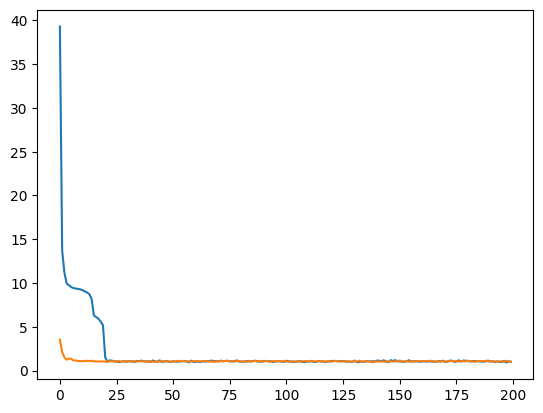

In [122]:
import matplotlib.pyplot as plt

model = AutoRec(epochs = 200)

# Train the model
train_list, test_list = model.fit()
train_tensor = torch.tensor(train_list)
test_tensor = torch.tensor(test_list)

plt.plot(train_tensor.detach().numpy()) # 근데 생각해보니 train_loss에는 regularization 포함돼서 같이 그릴 필요는 없는듯,,, 굳이 sqrt 한느낌
plt.plot(test_tensor.detach().numpy())

## 의문인점
성능은 왜 이모양,,,,
왜 baseline이 LLORMA인가